# Pose detection with yolov7 on colab

220922, by wygo

- [yolov7 공식 keypoint](https://github.com/WongKinYiu/yolov7/blob/main/tools/keypoint.ipynb)
- [yolov7 ref](https://stackabuse.com/pose-estimationkeypoint-detection-with-yolov7-in-python/)

# 0. 준비!

In [1]:
## setup
!git clone https://github.com/airobotlab/pose_detection.git
!git clone https://github.com/WongKinYiu/yolov7.git
%cd yolov7
! curl -L https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt -o yolov7-w6-pose.pt
%cd ..

Cloning into 'pose_detection'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.
Cloning into 'yolov7'...
remote: Enumerating objects: 963, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 963 (delta 0), reused 1 (delta 0), pack-reused 962
Receiving objects: 100% (963/963), 68.16 MiB | 11.13 MiB/s, done.
Resolving deltas: 100% (503/503), done.
/content/yolov7
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  153M  100  153M    0     0  6342k      0  0:00:24  0:00:24 --:--:-- 4019k
/content


In [2]:
## load
import os
import sys
sys.path.append("./yolov7")

import torch
from torchvision import transforms

from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

%matplotlib inline
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

def load_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = torch.load('yolov7/yolov7-w6-pose.pt', map_location=device)['model']
    # Put in inference mode
    model.float().eval()

    if torch.cuda.is_available():
        # half() turns predictions into float16 tensors
        # which significantly lowers inference time
        model.half().to(device)
    return model

model = load_model()

In [10]:
## functions
def make_mosaic(img_array, bboxes, n=10):
    # https://github.com/boostcampaitech3/final-project-level3-cv-11/blob/main/baselinewithfacenet/util.py
    # filling NxN kernel's max or average value
    # img_array: original image
    # bboxes: mosaic target positions, [[x_min, y_min, x_max, y_max], [~]]
    # n: kernel size

    for bbox in bboxes:
        bbox = np.round(bbox).astype(int)
        # 대상이 너무 작아 모자이크가 안된다면 pass
        if bbox[2] - bbox[0] < n or bbox[3] - bbox[1] < n:
            continue
        roi = img_array[bbox[1]:bbox[3], bbox[0]:bbox[2]] 
       # 1/n 비율로 축소
        roi = cv2.resize(roi, ((bbox[2] - bbox[0])//n,
                            (bbox[3] - bbox[1])//n),
                            interpolation=cv2.INTER_AREA)
        # 원래 크기로 확대
        roi = cv2.resize(roi, ((bbox[2] - bbox[0]),
                            (bbox[3] - bbox[1])),
                            interpolation=cv2.INTER_NEAREST)
        img_array[bbox[1]:bbox[3], bbox[0]:bbox[2]] = roi

    return img_array


## yolov7/utils/plots.py, plot_skeleton_kpts(im, kpts, steps, orig_shape=None)
def plot_skeleton_kpts_custom(image_array, kpts, steps=3, keypoint_confidence_threshold=0.5, plot_keypoint=True, plot_keyline=False, plot_mosaic=True):

    image_array_tmp = image_array.copy()
    image_size_y, image_size_x, _ = image_array_tmp.shape
    
    #Plot the skeleton and keypointsfor coco datatset
    palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                        [230, 230, 0], [255, 153, 255], [153, 204, 255],
                        [255, 102, 255], [255, 51, 255], [102, 178, 255],
                        [51, 153, 255], [255, 153, 153], [255, 102, 102],
                        [255, 51, 51], [153, 255, 153], [102, 255, 102],
                        [51, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0],
                        [255, 255, 255]])

    skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
                [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
                [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]

    pose_limb_color = palette[[9, 9, 9, 9, 7, 7, 7, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16]]
    pose_kpt_color = palette[[16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9]]
    radius = 5
    num_kpts = len(kpts) // steps  # 17

    
    ## 0) 출력데이터 정리, [[x, y, confidence], ..]
    list_keypoint_x_y_conf = []
    # 0, 1은 양쪽 귀. 그래서 2부터 해서 몸부분만 그리기 위해
    for kid in range(num_kpts):
        r, g, b = pose_kpt_color[kid]
        x_coord, y_coord = kpts[steps * kid], kpts[steps * kid + 1]  # kpts의 0번째가 x, 1번째가 y | 3번째가 x, 4번째가 y 이므로 3의 배수로 x/y 좌표가 나온다

        # confidence가 0.5 이상인 좌표만 가져가자
        # 640x640 이미지에서 태두리에 있으면 제외
        if not (x_coord % 640 == 0 or y_coord % 640 == 0):
            if steps == 3:
                confidence = kpts[steps * kid + 2]  # 0번짼 x, 1번짼 y, 2번짼 confidence
                list_keypoint_x_y_conf.append([x_coord, y_coord, confidence])

    # 얼굴은 제외, 첫 5개는 얼굴부분
    list_keypoint_x_y_conf = list_keypoint_x_y_conf[5:]
                
                
    ## 1) keypoint 찍기, x/y/confidence로 이뤄져있다. conf>0.5만 가져가자
    if plot_keypoint:
        for idx, (x_coord, y_coord, confidence) in enumerate(list_keypoint_x_y_conf):
            r, g, b = pose_kpt_color[idx]
            if confidence > keypoint_confidence_threshold:
                cv2.circle(image_array_tmp, (int(x_coord), int(y_coord)), radius, (int(r), int(g), int(b)), -1)


    ## 2) 선긋기
    if plot_keyline:
        for sk_id, sk in enumerate(skeleton):
            r, g, b = pose_limb_color[sk_id]
            pos1 = (int(kpts[(sk[0]-1)*steps]), int(kpts[(sk[0]-1)*steps+1]))
            pos2 = (int(kpts[(sk[1]-1)*steps]), int(kpts[(sk[1]-1)*steps+1]))
            if steps == 3:
                conf1 = kpts[(sk[0]-1)*steps+2]
                conf2 = kpts[(sk[1]-1)*steps+2]
                if conf1<0.5 or conf2<0.5:
                    continue
            if pos1[0]%640 == 0 or pos1[1]%640==0 or pos1[0]<0 or pos1[1]<0:
                continue
            if pos2[0] % 640 == 0 or pos2[1] % 640 == 0 or pos2[0]<0 or pos2[1]<0:
                continue
            cv2.line(image_array_tmp, pos1, pos2, (int(r), int(g), int(b)), thickness=2)



    ## 3) mosaic
    if plot_mosaic:
        
        # 20% 마진두고 박스치기
        x_points = [tmp[0] for tmp in list_keypoint_x_y_conf]
        y_points = [tmp[1] for tmp in list_keypoint_x_y_conf]
        x_min, x_max, y_min, y_max = int(min(x_points)), int(max(x_points)), int(min(y_points)), int(max(y_points))

        margine = 120  # 20% 마진 더 크게
        distance_x = (x_max - x_min)
        distance_y = (y_max - y_min)
    
        x_min_margine = max(int((x_min + x_max)/2) - int((distance_x * (margine/100))/2), 0)  # 784
        x_max_margine = min(int((x_min + x_max)/2) + int((distance_x * (margine/100))/2), image_size_x)
        y_min_margine = max(int((y_min + y_max)/2) - int((distance_y * (margine/100))/2), 0)
        y_max_margine = min(int((y_min + y_max)/2) + int((distance_y * (margine/100))/2), image_size_y)    
        bboxes_margine = [[x_min_margine, y_min_margine, x_max_margine, y_max_margine]]

#         print(x_min, y_min, x_max, y_max)
#         print(x_min_margine, y_min_margine, x_max_margine, y_max_margine)
        
        # body 부분 bbox 그리기, 딱맞게랑 20% 마진있게
#         cv2.rectangle(image_array_tmp, (x_min, y_min), (x_max, y_max), (255, 0, 0), 1)
#         cv2.rectangle(image_array_tmp, (x_min_margine, y_min_margine), (x_max_margine, y_max_margine), (0, 255, 0), 1)

        image_array_tmp = make_mosaic(image_array_tmp, bboxes_margine)    
    
    return image_array_tmp, list_keypoint_x_y_conf


def run_inference(img_path):
    image = cv2.imread(img_path) # shape: (480, 640, 3)
    # Resize and pad image
    image = letterbox(image, 960, stride=64, auto=True)[0] # shape: (768, 960, 3)
    # Apply transforms
    image = transforms.ToTensor()(image) # torch.Size([3, 768, 960])
    # Turn image into batch
    image = image.unsqueeze(0) # torch.Size([1, 3, 768, 960])
    output_model, _ = model(image) # torch.Size([1, 45900, 57])
    return output_model, image


def skeleton_detection_postprocessing(output_model,
                                      output_skeleton_path='output_skeleton.jpg',
                                      nms_confidence_threshold=0.25,
                                      nms_IOU_threshold=0.65,
                                      plot_keypoint = False, 
                                      plot_keyline = False, 
                                      plot_mosaic = True,
                                      plot_display=True):

    # 1) nms
    output_nms = non_max_suppression_kpt(output_model,
                                         nms_confidence_threshold,  # Confidence Threshold
                                         nms_IOU_threshold,  # IoU Threshold
                                         # Number of Classes
                                         nc=model.yaml['nc'],
                                         # Number of Keypoints
                                         nkpt=model.yaml['nkpt'],
                                         kpt_label=True)

    # 2) 정리
    with torch.no_grad():
        # output_keypoint: 사람수, keypoint 좌표, ex) (12, 58)\
        # [batch_id, class_id, x, y, w, h, conf]
        output_keypoint = output_to_keypoint(output_nms)

    # img_array: (704, 960, 3) 행렬
    img_array = image[0].permute(1, 2, 0) * 255
    img_array = img_array.cpu().numpy().astype(np.uint8)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    img_array_new = img_array.copy()
    # keypoints_result = output_keypoint[idx, 7:].T

    # 3) plot!
#     idx = 5
#     img_array_new = plot_skeleton_kpts_custom(img_array_new, output_keypoint[idx, 7:].T, plot_keypoint=plot_keypoint, plot_keyline=plot_keyline, plot_mosaic=plot_mosaic)

    list_list_keypoint_x_y_conf = []
    for idx in range(len(output_keypoint)):

#         print(output_keypoint[idx, 7:].T.shape)
        img_array_new, list_keypoint_x_y_conf = plot_skeleton_kpts_custom(img_array_new, output_keypoint[idx, 7:].T, plot_keypoint=plot_keypoint, plot_keyline=plot_keyline, plot_mosaic=plot_mosaic)
        list_list_keypoint_x_y_conf.append(list_keypoint_x_y_conf)
    
    
    if plot_display:
        display(Image.fromarray(img_array_new))
    # save
    img_array_new_bgr = cv2.cvtColor(img_array_new, cv2.COLOR_BGR2RGB)
    cv2.imwrite(output_skeleton_path, img_array_new_bgr)  # save
    return img_array_new, list_list_keypoint_x_y_conf

# 1. 입력데이터 셋팅

In [4]:
## load image
data_root = 'pose_detection/data'
image_name = '1.jpg'
# image_name = '2.jpg'
# image_name = '3.jpg'
# image_name = '4.jpg'
# image_name = '5.jpg'
# image_name = '6.jpg'
# image_name = '7.jpg'

img_path = os.path.join(data_root, image_name)

# 2. pose detection 모델 실행

In [5]:
%%time
## run model
output_model, image = run_inference(img_path=img_path)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


CPU times: user 3.41 s, sys: 1.1 s, total: 4.51 s
Wall time: 4.79 s


# 3. Post-processing

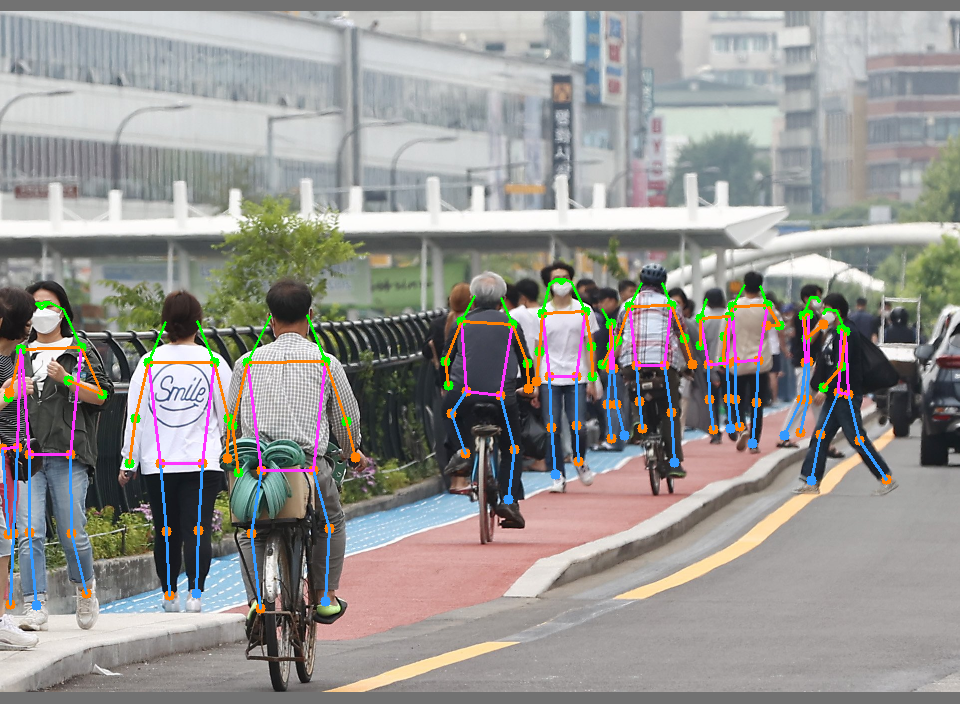

CPU times: user 354 ms, sys: 2.45 ms, total: 356 ms
Wall time: 360 ms


In [11]:
%%time
## display, skeleton
output_image, list_list_keypoint_x_y_conf = skeleton_detection_postprocessing(output_model, output_skeleton_path='output_skeleton.jpg',
                                                                              plot_display=True,
                                                                              plot_keypoint=True, plot_keyline=True, plot_mosaic=False)

In [12]:
list_list_keypoint_x_y_conf[0]

[[148.70150756835938, 362.54296875, 0.9886605739593506],
 [214.52828979492188, 362.6030578613281, 0.9808706641197205],
 [135.4959716796875, 418.1755676269531, 0.9403313994407654],
 [228.49688720703125, 418.2433166503906, 0.8236581087112427],
 [129.5208282470703, 463.282958984375, 0.7492366433143616],
 [227.4996337890625, 458.7764892578125, 0.5016478300094604],
 [160.63230895996094, 463.0506896972656, 0.9890825748443604],
 [202.63201904296875, 463.0956115722656, 0.9853264093399048],
 [166.2550811767578, 531.0914916992188, 0.9675586819648743],
 [198.63043212890625, 530.8660888671875, 0.9546055793762207],
 [169.92381286621094, 595.323974609375, 0.9052556753158569],
 [196.83644104003906, 593.7332763671875, 0.8821109533309937]]

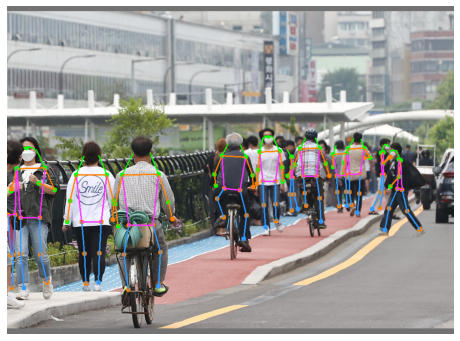

In [7]:
%matplotlib inline
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(output_image)
plt.show()

# Colab 구독 최대한 활용하기

